Link: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [2]:
# Define relative paths to DTM and DSM files
dtm_path = os.path.join("data", "colorado-flood", "spatial",
                        "boulder-leehill-rd", "pre-flood", "lidar",
                        "pre_DTM.tif")

dsm_path = os.path.join("data", "colorado-flood", "spatial",
                        "boulder-leehill-rd", "pre-flood", "lidar",
                        "pre_DSM.tif")

# Open DTM and DSM files
with rio.open(dtm_path) as src:
    lidar_dtm_im = src.read(1, masked=True)
    spatial_extent = plotting_extent(src)

with rio.open(dsm_path) as src:
    lidar_dsm_im = src.read(1, masked=True)
    spatial_extent = plotting_extent(src)

# Create canopy height model (CHM)    
lidar_chm_im = lidar_dsm_im - lidar_dtm_im
lidar_chm_im

masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [3]:
# View min and max values in the data
print('CHM min value:', lidar_chm_im.min())
print('CHM max value:', lidar_chm_im.max())

CHM min value: 0.0
CHM max value: 26.930054


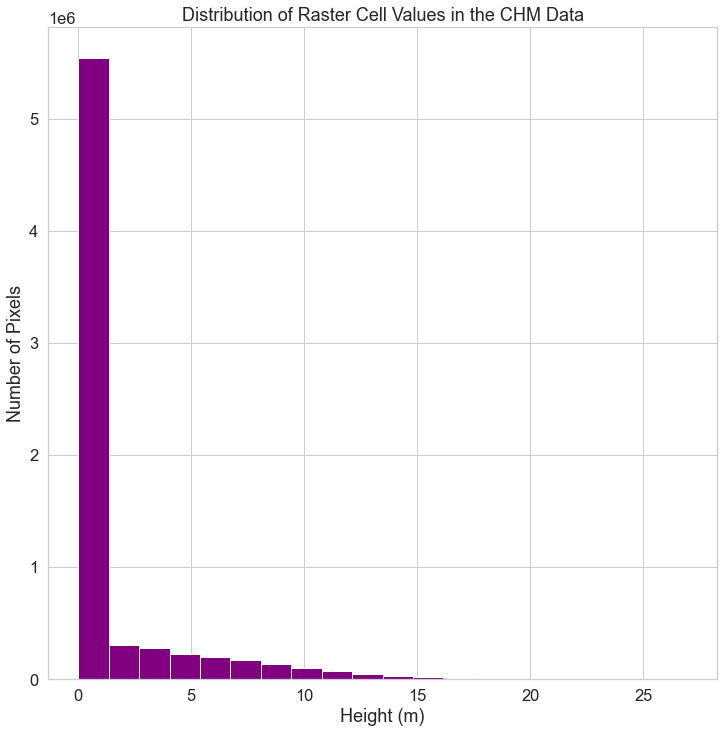

In [4]:
ep.hist(lidar_chm_im.ravel(),
        title="Distribution of Raster Cell Values in the CHM Data",
        xlabel="Height (m)",
        ylabel="Number of Pixels")

plt.show()

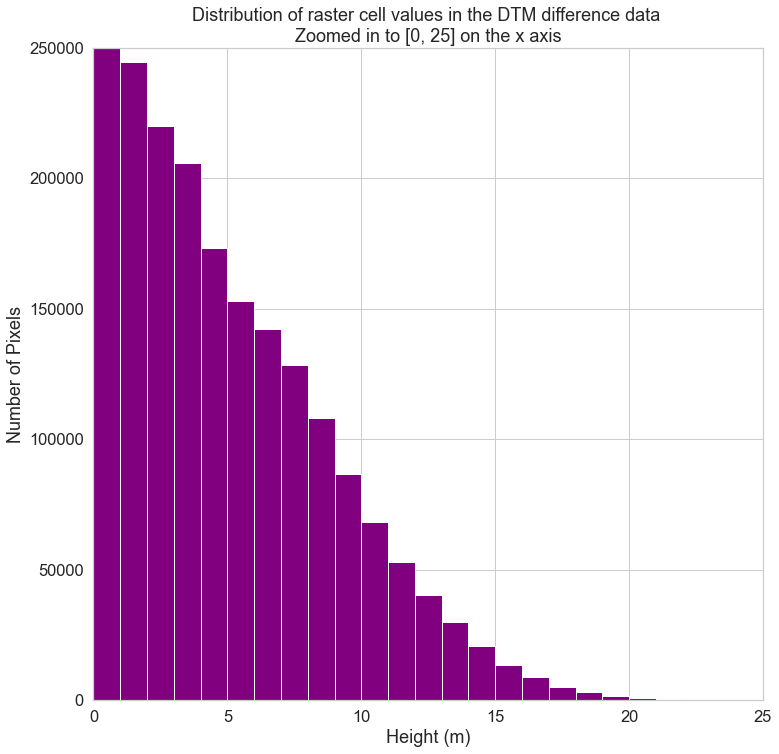

In [5]:
# Create histogram with xlim and ylim
xlim = [0, 25]

f, ax = ep.hist(lidar_chm_im.ravel(),
                hist_range=xlim,
                bins=range(*xlim),
                ylabel="Number of Pixels", xlabel="Height (m)",
                title="Distribution of raster cell values in the DTM difference data \n" +
                      "Zoomed in to {} on the x axis".format(xlim))

ax.set(xlim=xlim, ylim=[0, 250000])

plt.show()

In [6]:
# Get counts and bins
counts, bins = np.histogram(lidar_chm_im,
                            bins=50, 
                            range=xlim)

print("counts:", counts)
print("bins:", bins)

counts: [5292785  155317  128037  116551  109743  110395  107528   98579   89234
   83947   79123   73934   71669   70521   67043   61639   56389   51932
   46193   40674   36442   31877   28428   24553   21620   18613   16095
   13776   11424    9402    7504    6195    4883    3901    2954    2306
    1776    1342    1027     706     525     358     271     160     113
      99      47      44      21      16]
bins: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25. ]


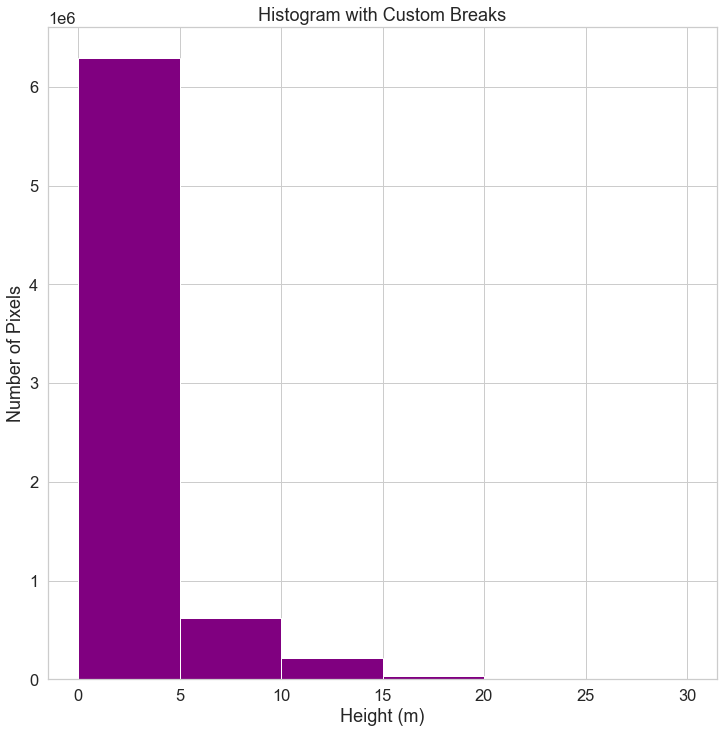

In [7]:
# Histogram with custom breaks
ep.hist(lidar_chm_im.ravel(),
        bins=[0, 5, 10, 15, 20, 30],
        title="Histogram with Custom Breaks",
        xlabel="Height (m)", 
        ylabel="Number of Pixels")

plt.show()

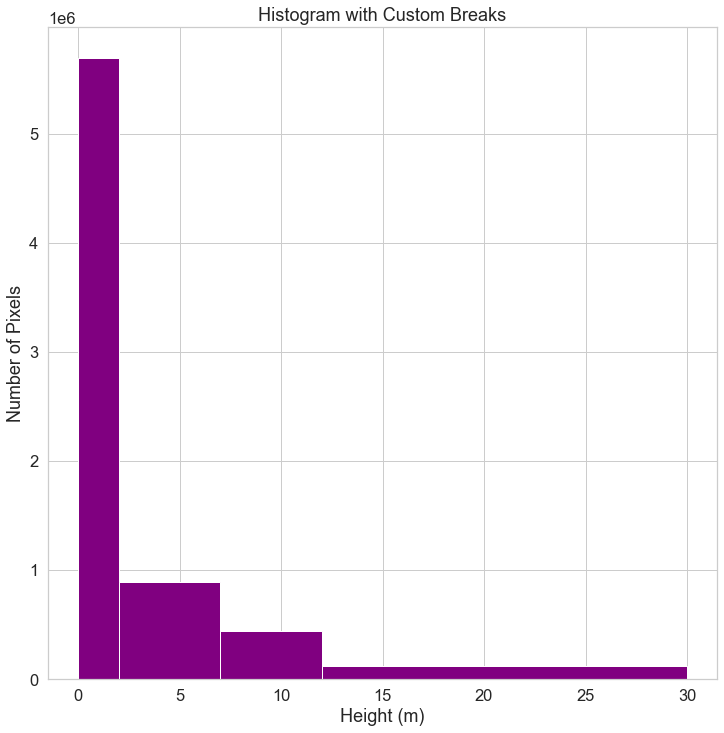

In [8]:
ep.hist(lidar_chm_im.ravel(),
        colors='purple',
        bins=[0, 2, 7, 12, 30],
        title="Histogram with Custom Breaks",
        xlabel="Height (m)",
        ylabel="Number of Pixels")

plt.show()

In [9]:
# Check fill value for your array
lidar_chm_im.fill_value

-3.402823e+38

In [10]:
# Define bins that you want, and then classify the data
class_bins = [lidar_chm_im.min(), 2, 7, 12, np.iinfo(np.int32).max]

# Classify the original image array, then unravel it again for plotting
lidar_chm_im_class = np.digitize(lidar_chm_im, class_bins)

# Note that you have an extra class in the data (0)
print(np.unique(lidar_chm_im_class))

[0 1 2 3 4]


In [11]:
type(lidar_chm_im_class)

numpy.ndarray

In [12]:
# Reassign all values that are classified as 0 to masked (no data value)
# This will prevent pixels that == 0 from being rendered on a map in matplotlib
lidar_chm_class_ma = np.ma.masked_where(lidar_chm_im_class == 0,
                                        lidar_chm_im_class,
                                        copy=True)
lidar_chm_class_ma

masked_array(
  data=[[--, --, --, ..., 1, 1, 1],
        [--, --, --, ..., 1, 1, 1],
        [--, --, --, ..., 1, 1, 1],
        ...,
        [--, --, --, ..., 1, 1, 1],
        [--, --, --, ..., 1, 1, 1],
        [--, --, --, ..., 1, 1, 1]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=999999,
  dtype=int64)

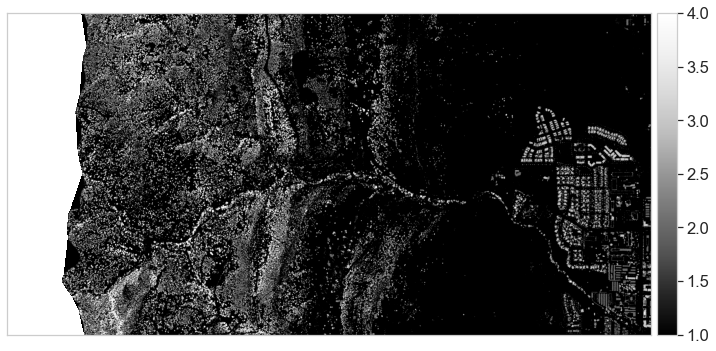

In [13]:
# Plot newly classified and masked raster
ep.plot_bands(lidar_chm_class_ma,
              scale=False)
plt.show()

In [14]:
# Check classes
np.unique(lidar_chm_class_ma)

masked_array(data=[1, 2, 3, 4, --],
             mask=[False, False, False, False,  True],
       fill_value=999999,
            dtype=int64)

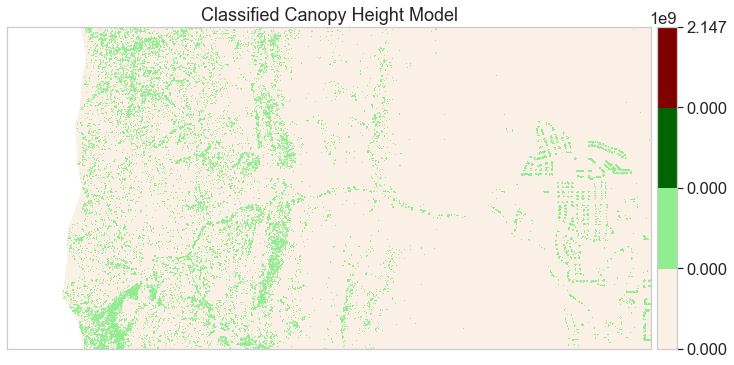

In [15]:
# Plot data using nicer colors
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']

cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, len(colors))

ep.plot_bands(lidar_chm_class_ma,
              cmap=cmap,
              title="Classified Canopy Height Model",
              scale=False,
              norm=norm)
plt.show()

In [16]:
# Check classes
np.unique(lidar_chm_class_ma)

masked_array(data=[1, 2, 3, 4, --],
             mask=[False, False, False, False,  True],
       fill_value=999999,
            dtype=int64)

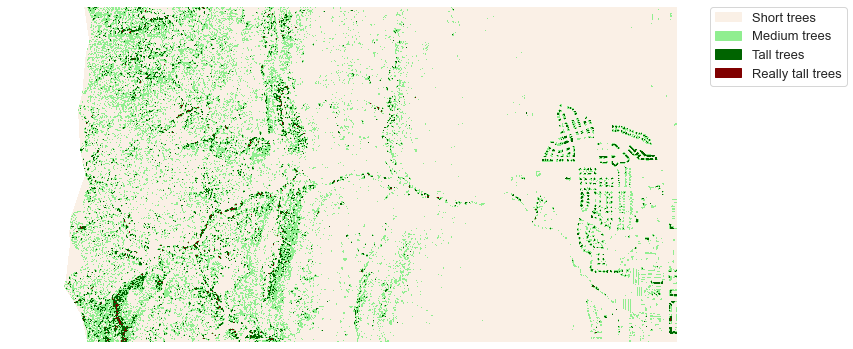

In [17]:
# Create a list of labels to use for your legend
height_class_labels = ["Short trees", "Medium trees",
                       "Tall trees", "Really tall trees"]

# Create a colormap from a list of colors
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']
cmap = ListedColormap(colors)

f, ax = plt.subplots(figsize=(12, 12))

im = ax.imshow(lidar_chm_class_ma,
               cmap=cmap)

ep.draw_legend(im, titles=height_class_labels)
ax.set_axis_off()

plt.show()